In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [58]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import numpy as np
import torch
import math

class_names = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I'
}

transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.ToPILImage(),
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

# Load the data with all of the classes
data = datasets.ImageFolder(root='../lab3data', transform=None)
data_list = np.array(data.imgs)

# Get the indices for the train/val/test split of 75/15/15
train_split = math.floor(0.7 * len(data))
val_split = math.ceil(0.15 * len(data))
test_split = val_split

# print(train_split + val_split + test_split, len(data_arr))

# Make sure the splits are correct
assert train_split + val_split + test_split == len(data)

# Split the dataset randomely
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(data, [train_split, val_split, test_split], generator=generator)

len(train), len(val), len(test)


(1553, 333, 333)

In [29]:
import cv2

class GenData(torch.utils.data.Dataset):
    '''
        Data set class to store the feature maps
    
    '''

    def __init__(self, in_data, transform=None):
        data = np.array(in_data)
        self.input_dirs = data[:, 0]
        self.labels = data[:, 1]
        self.input_transform = transform[0]
        self.transform = transform[1]
        self.resize_transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(128)
                                ])


    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        input_dir = self.input_dirs[idx]

        # Load the data
        inputs = cv2.imread(input_dir)
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2RGB)
        # inputs = inputs.swapaxes(0, 2)

        labels = (int)(self.labels[idx])

        if self.transform:
            inputs = self.input_transform(inputs)
            transformed = self.transform(inputs)

            # labels = self.input_transform(labels)

            return inputs, transformed, labels
        else:
            return inputs, inputs, labels

In [4]:
# Create data loaders
def get_data_loaders(batch_size=1):
    
    train_data = GenData(data_list[train.indices], transform=(transform, transform))
    val_data = GenData(data_list[val.indices], transform=(transform, transform))
    test_data = GenData(data_list[test.indices], transform=(transform, transform))

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader



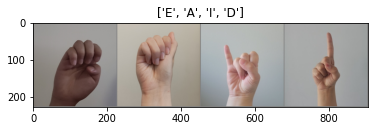

In [5]:
'''Code to visualize the data in the training set'''

import torchvision


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
train_dataloader, _, _ = get_data_loaders(4)
inputs, _, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x.item()] for x in classes])

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class VAENet(nn.Module):
    def __init__(self, name="BirdNet", transfer_model=None, transfer_ftrs=64):
        super(VAENet, self).__init__()

        self.name = name
        self.transfer_model = transfer_model
        self.transfer_ftrs = transfer_ftrs

        self.latent_dim = 100

        self.front = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=3), # 224 --> 72 = (224 + 0 - 11)/3 + 1
            nn.MaxPool2d(kernel_size=3, stride=3), # 72 --> 24 = (72 + 0 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(96),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1, stride=1), # 24 --> 24 = (24 + 2 - 3)/1 + 1
            nn.MaxPool2d(kernel_size=4, stride=2), # 24 --> 11 (24 + 6 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            nn.ReLU(),
            nn.BatchNorm2d(384),

            # nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            # nn.ReLU(),
            # nn.BatchNorm2d(384),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), # 11 --> 11 = (10 + 2 - 3)/1 + 1
            nn.MaxPool2d(kernel_size=3, stride=2), # 11 --> 5 = (11 + 0 - 3)/2 + 1
            nn.ReLU(),
            nn.BatchNorm2d(256),

        )

        self.muFC = nn.Linear(5 * 5 * 256, self.latent_dim)
        self.logvarFC = nn.Linear(5 * 5 * 256, self.latent_dim)

        self.transfer_muFC = nn.Linear(self.transfer_ftrs, self.latent_dim)
        self.transfer_logvarFC = nn.Linear(self.transfer_ftrs, self.latent_dim)

        self.latentFC = nn.Linear(self.latent_dim, 5 * 5 * 256)

        self.back = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=384, kernel_size=3, stride=2, padding=0, output_padding=0), # 5 -> 11
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.ConvTranspose2d(in_channels=384, out_channels=256, kernel_size=3, padding=0, stride=2, output_padding=1), # 11 -> 24
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(in_channels=256, out_channels=96, kernel_size=3, padding=0, stride=3, output_padding=0), # 24 -> 72
            nn.ReLU(),
            nn.BatchNorm2d(96),

            nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=11, padding=0, stride=3, output_padding=0), # 72 -> 224
            # nn.ReLU()
        )

    def encoder(self, x):

        mu, logvar = None, None

        if not self.transfer_model:
            x = self.front(x)
            x = x.view(-1, 5 * 5 * 256)

            mu = self.muFC(x)
            logvar = self.logvarFC(x)

        else:
            x = self.transfer_model(x)
            x = x.view(-1, self.transfer_ftrs)

            mu = self.transfer_muFC(x)
            logvar = self.transfer_logvarFC(x)

        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)
    
    def decoder (self, x):
        x = self.latentFC(x)
        x = x.view(-1, 256, 5, 5)

        x = self.back(x)
        x = F.softmax(x, 0)

        return x

    def forward(self, x):
        # x = self.forward_pass(x)
        # x = x.squeeze(1)
        # x = F.softmax(x, dim=1)

        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        y = self.decoder(z)
        
        return y, z, mu, logvar

In [43]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class VAENetSmall(nn.Module):
    def __init__(self, name="BirdNet", transfer_model=None, transfer_ftrs=64):
        super(VAENetSmall, self).__init__()

        self.name = name
        self.transfer_model = transfer_model
        self.transfer_ftrs = transfer_ftrs

        self.latent_dim = 256

        self.front = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=36, kernel_size=11, stride=3), # 224 --> 40 = (128 + 0 - 11)/3 + 1
            # nn.MaxPool2d(kernel_size=3, stride=3), # 72 --> 24 = (72 + 0 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(36),
            nn.Dropout(0.5),

            nn.Conv2d(in_channels=36, out_channels=64, kernel_size=3, padding=1, stride=2), # 40 --> 20 = (40 + 2 - 3)/2 + 1
            # nn.MaxPool2d(kernel_size=4, stride=2), # 24 --> 11 (24 + 6 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2), # 20 --> 10 = (20 + 2 - 3)/2 + 1
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5),

            # nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            # nn.ReLU(),
            # nn.BatchNorm2d(384),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=2), # 10 --> 5 = (10 + 2 - 3)/1 + 1
            # nn.MaxPool2d(kernel_size=3, stride=2), # 11 --> 5 = (11 + 0 - 3)/2 + 1
            nn.ReLU(),
            nn.BatchNorm2d(64),

        )

        self.muFC = nn.Linear(5 * 5 * 64, self.latent_dim)
        self.logvarFC = nn.Linear(5 * 5 * 64, self.latent_dim)

        self.transfer_muFC = nn.Linear(self.transfer_ftrs, self.latent_dim)
        self.transfer_logvarFC = nn.Linear(self.transfer_ftrs, self.latent_dim)

        self.latentFC = nn.Linear(self.latent_dim, 5 * 5 * 64)

        self.back = nn.Sequential(
            #nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0, output_padding=0), # 5 -> 11
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1), # 5 -> 10
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=2, output_padding=1), # 10 -> 20
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=2, output_padding=1), # 20 -> 40
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.5),

            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=11, padding=0, stride=3, output_padding=0), # 40 -> 128
            # nn.ReLU()
        )

    def encoder(self, x):

        mu, logvar = None, None

        if not self.transfer_model:
            x = self.front(x)
            x = x.view(-1, 5 * 5 * 64)

            mu = self.muFC(x)
            logvar = self.logvarFC(x)

        else:
            x = self.transfer_model(x)
            x = x.view(-1, self.transfer_ftrs)

            mu = self.transfer_muFC(x)
            logvar = self.transfer_logvarFC(x)

        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)
    
    def decoder (self, x):
        x = self.latentFC(x)
        x = x.view(-1, 64, 5, 5)

        x = self.back(x)
        x = F.softmax(x)

        return x

    def forward(self, x):
        # x = self.forward_pass(x)
        # x = x.squeeze(1)
        # x = F.softmax(x, dim=1)

        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        y = self.decoder(z)
        
        return y, z, mu, logvar

In [34]:
from torchsummary import summary

model = VAENetSmall()
model.to('cuda:0')

summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 36, 40, 40]          13,104
              ReLU-2           [-1, 36, 40, 40]               0
       BatchNorm2d-3           [-1, 36, 40, 40]              72
           Dropout-4           [-1, 36, 40, 40]               0
            Conv2d-5           [-1, 64, 20, 20]          20,800
              ReLU-6           [-1, 64, 20, 20]               0
       BatchNorm2d-7           [-1, 64, 20, 20]             128
           Dropout-8           [-1, 64, 20, 20]               0
            Conv2d-9          [-1, 128, 10, 10]          73,856
             ReLU-10          [-1, 128, 10, 10]               0
      BatchNorm2d-11          [-1, 128, 10, 10]             256
          Dropout-12          [-1, 128, 10, 10]               0
           Conv2d-13             [-1, 64, 5, 5]          73,792
             ReLU-14             [-1, 6

C:\Users\ammar\AppData\Local\Temp\ipykernel_25564\3683086511.py:105: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [31]:
'''
Loss function
'''

def vaekl_loss(recon_x, x, mu, logvar, batch_size):
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= batch_size * 3 * 128 * 128
    return kld

In [73]:
'''
Helper functions (based off of previous labs)
'''

def calculate_error(inputs, target):
    difference = torch.abs(target - inputs)
    mean_error = torch.mean(difference, dim=-1) # mean along width
    mean_error = torch.mean(mean_error, dim=-1) # mean along height
    mean_error = torch.mean(mean_error, dim=-1) # mean along channel

    # print(difference.size())
    # print(mean_error.size())
    # print(mean_error)

    return mean_error.sum()  


def evaluate(model, loader, criterion, cuda=False, batch_size=64, alex=False):
    '''
    Function to evaluate the model's performance on a val/test set
    '''


    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, transformed, labels = data

        ########## SENDING TO CUDA ############
        if cuda:
            inputs = inputs.to('cuda:0')
            transformed = transformed.to('cuda:0')
            
        

        outputs, latent_vector, mu, logvar = model(transformed)

        if alex:
            labels = labels.squeeze(1)

        # loss = 200 * criterion(outputs, inputs.float()) + 200 * vaekl_loss(outputs, inputs, mu, logvar, batch_size)
        loss =  model.loss_function(outputs, inputs, mu, logvar, M_N=1000)['loss']


        # Find the mean error over the image
        output_err = calculate_error(outputs, inputs) 

        total_err += output_err
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss


def get_model_name(name, batch_size, learning_rate, momentum, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_m{3}_epoch{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   momentum,
                                                   epoch)
    return path


# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [72]:
'''
Train Loop
'''

import tqdm
import time
from torch.optim import lr_scheduler

OUTPUT_DIR = 'runs/'

def train_network(model, batch_size=32, lr=0.005, momentum=0.9, num_epochs=30, cuda=True, loader=None, alex=False, sheduler=False):

    # Set manual seed for reproducible results
    torch.manual_seed(1)

    # Get the dataloaders with respective batch size
    train_dl, val_dl, _ = get_data_loaders(batch_size=batch_size)

    # Criterion and optimizer
    criterion = nn.MSELoss()
    # optimizer =  optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    optimizer =  optim.Adam(model.parameters(), lr=lr)

    if sheduler:
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)



    # Training metrics
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    best_train_err = 1000
    best_val_err = 1000

    ########## SENDING TO CUDA ############
    if cuda:
        model = model.to('cuda:0')

    start_time = time.time()
    model.train()

    # Train loop
    for epoch in tqdm.tqdm(range(num_epochs)):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0

        for i, data in enumerate(train_dl if not loader else loader):

            inputs, transformed, labels = data


            ########## SENDING TO CUDA ############
            if cuda:
                inputs = inputs.to('cuda:0')
                transformed = transformed.to('cuda:0')

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs, latent_vector, mu, logvar = model(transformed)

            if alex:
                labels = labels.squeeze(1)

            # loss = 200 * criterion(outputs, inputs.float()) + 200 * vaekl_loss(outputs, inputs, mu, logvar, batch_size)
            loss =  model.loss_function(outputs, inputs, mu, logvar, M_N=1000)['loss']
            loss.backward()
            optimizer.step()

            # Find the mean error over the image
            output_err = calculate_error(outputs, inputs)

            total_train_err += output_err
            total_train_loss += loss.item()
            total_epoch += len(labels)

        if sheduler:
            exp_lr_scheduler.step()

        train_err[epoch] = float(total_train_err) / (total_epoch)
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_err[epoch], val_loss[epoch] = evaluate(model, val_dl if not loader else loader, criterion, cuda, batch_size, alex)

        tqdm.tqdm.write(f'Epoch {epoch}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}')

        # Check whether a better train/val err has been found
        better = False
        if train_err[epoch] < best_train_err:
            best_train_err = train_err[epoch]
            better = True
        if val_err[epoch] < best_val_err:
            best_val_err = val_err[epoch]
            better = True

        if better or epoch == (num_epochs - 1):
            model_path = OUTPUT_DIR + get_model_name(model.name, batch_size, lr, momentum, epoch)

            torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)



In [12]:
from torchvision import models


model_ft = models.resnet18(pretrained=True) # IMAGENET1K_V1
model_ft.name = 'resent_small'
count = 0
for param in model_ft.parameters():
    # if count > 30:
    #     break
    param.requires_grad = False
    count += 1

print(count)
num_ftrs = model_ft.fc.in_features

62


In [87]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

from torch import nn
from abc import abstractmethod

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

import torch
# from models import BaseVAE
from torch import nn
from torch.nn import functional as F
# from .types_ import *


class VanillaVAE(BaseVAE):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                    nn.Dropout(0.4))
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                    nn.Dropout(0.4))
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

  2%|▏         | 1/50 [00:04<03:45,  4.60s/it]

Epoch 0: Train err: 0.31822557320382927, Train loss: 3610530.57203125 | Validation err: 0.28425611891188063, Validation loss: 47779.46875


  4%|▍         | 2/50 [00:09<03:37,  4.52s/it]

Epoch 1: Train err: 0.28180432734148625, Train loss: 44311.96828125 | Validation err: 0.28228784967829157, Validation loss: 79442.92708333333


  6%|▌         | 3/50 [00:13<03:37,  4.62s/it]

Epoch 2: Train err: 0.27485510340369446, Train loss: 883119.00828125 | Validation err: 0.2746271127695078, Validation loss: 34989.642903645836


  8%|▊         | 4/50 [00:19<03:52,  5.05s/it]

Epoch 3: Train err: 0.2708750845767265, Train loss: 43196.510859375 | Validation err: 0.27309264220274965, Validation loss: 35292.290690104164


 10%|█         | 5/50 [00:24<03:49,  5.11s/it]

Epoch 4: Train err: 0.26887778474374197, Train loss: 36438.29703125 | Validation err: 0.27007254752310905, Validation loss: 30307.0


 12%|█▏        | 6/50 [00:29<03:44,  5.10s/it]

Epoch 5: Train err: 0.26663577441469133, Train loss: 218892.9553125 | Validation err: 0.2687799493829767, Validation loss: 50985.925130208336


 14%|█▍        | 7/50 [00:34<03:36,  5.03s/it]

Epoch 6: Train err: 0.25841689739239576, Train loss: 59515.55515625 | Validation err: 0.24836002384220157, Validation loss: 52882.645182291664


 16%|█▌        | 8/50 [00:39<03:29,  5.00s/it]

Epoch 7: Train err: 0.23813709227100774, Train loss: 54114.35640625 | Validation err: 0.24137988391223256, Validation loss: 50495.887369791664


 18%|█▊        | 9/50 [00:46<03:44,  5.46s/it]

Epoch 8: Train err: 0.23123976590168221, Train loss: 60848.119375 | Validation err: 0.23088536534581455, Validation loss: 53403.69921875


 20%|██        | 10/50 [00:51<03:34,  5.36s/it]

Epoch 9: Train err: 0.22787253532728993, Train loss: 48941.0259375 | Validation err: 0.22165883840383352, Validation loss: 43944.938802083336


 22%|██▏       | 11/50 [00:56<03:28,  5.35s/it]

Epoch 10: Train err: 0.22535195630055738, Train loss: 46572.123125 | Validation err: 0.22765842930332678, Validation loss: 44105.969401041664


 24%|██▍       | 12/50 [01:01<03:13,  5.08s/it]

Epoch 11: Train err: 0.2255631033559039, Train loss: 58007.1771875 | Validation err: 0.22628213693429758, Validation loss: 51318.912760416664


 26%|██▌       | 13/50 [01:05<03:03,  4.97s/it]

Epoch 12: Train err: 0.22522937506917057, Train loss: 202838.74 | Validation err: 0.22080171144044436, Validation loss: 62473.238932291664


 28%|██▊       | 14/50 [01:10<02:53,  4.83s/it]

Epoch 13: Train err: 0.22292837325941725, Train loss: 64495.99671875 | Validation err: 0.21984604385880022, Validation loss: 56917.748046875


 30%|███       | 15/50 [01:14<02:44,  4.70s/it]

Epoch 14: Train err: 0.22308687601869365, Train loss: 61063.53546875 | Validation err: 0.23559716943506007, Validation loss: 1287076.51171875


 32%|███▏      | 16/50 [01:18<02:35,  4.57s/it]

Epoch 15: Train err: 0.22390230256207744, Train loss: 68804.02359375 | Validation err: 0.22881828056083428, Validation loss: 58296.093098958336


 34%|███▍      | 17/50 [01:23<02:30,  4.55s/it]

Epoch 16: Train err: 0.22810215406546805, Train loss: 60936.29453125 | Validation err: 0.227212487756311, Validation loss: 55956.669270833336


 36%|███▌      | 18/50 [01:27<02:25,  4.54s/it]

Epoch 17: Train err: 0.22367883450126771, Train loss: 56230.83390625 | Validation err: 0.22625668270809873, Validation loss: 50727.563802083336


 38%|███▊      | 19/50 [01:32<02:22,  4.59s/it]

Epoch 18: Train err: 0.2226422979842442, Train loss: 54943.600625 | Validation err: 0.2235313392616249, Validation loss: 61556.26171875


 40%|████      | 20/50 [01:37<02:21,  4.73s/it]

Epoch 19: Train err: 0.2224559894470883, Train loss: 54722.0884375 | Validation err: 0.22149154159041853, Validation loss: 47057.036458333336


 42%|████▏     | 21/50 [01:43<02:29,  5.14s/it]

Epoch 20: Train err: 0.222040946454443, Train loss: 51654.2078125 | Validation err: 0.2228020562065972, Validation loss: 43167.748046875


 44%|████▍     | 22/50 [01:49<02:32,  5.43s/it]

Epoch 21: Train err: 0.22237202189311012, Train loss: 52342.431875 | Validation err: 0.22223502952415305, Validation loss: 145470.759765625


 46%|████▌     | 23/50 [01:54<02:17,  5.11s/it]

Epoch 22: Train err: 0.22192557703965107, Train loss: 142528.85234375 | Validation err: 0.22111598292628565, Validation loss: 78479.62760416667


 48%|████▊     | 24/50 [01:58<02:09,  4.98s/it]

Epoch 23: Train err: 0.22164097556895926, Train loss: 87021.47375 | Validation err: 0.2207293123812289, Validation loss: 86255.54557291667


 50%|█████     | 25/50 [02:03<02:03,  4.93s/it]

Epoch 24: Train err: 0.22176055023920435, Train loss: 95583.4975 | Validation err: 0.22204972459031297, Validation loss: 109495.7109375


 52%|█████▏    | 26/50 [02:08<01:58,  4.95s/it]

Epoch 25: Train err: 0.22161493835645726, Train loss: 93191.5025 | Validation err: 0.22181529826946086, Validation loss: 88115.93359375


 54%|█████▍    | 27/50 [02:13<01:55,  5.01s/it]

Epoch 26: Train err: 0.22127213143411945, Train loss: 90511.7484375 | Validation err: 0.22092687475072728, Validation loss: 84935.33463541667


 56%|█████▌    | 28/50 [02:18<01:49,  4.97s/it]

Epoch 27: Train err: 0.22112068328562662, Train loss: 90689.2871875 | Validation err: 0.221081616284253, Validation loss: 83181.19140625


 58%|█████▊    | 29/50 [02:23<01:41,  4.83s/it]

Epoch 28: Train err: 0.22100894925522174, Train loss: 87520.6528125 | Validation err: 0.22204509654918592, Validation loss: 80638.90234375


 60%|██████    | 30/50 [02:27<01:35,  4.76s/it]

Epoch 29: Train err: 0.22099393610023946, Train loss: 79678.993125 | Validation err: 0.22112814871756523, Validation loss: 77095.77083333333


 62%|██████▏   | 31/50 [02:32<01:28,  4.66s/it]

Epoch 30: Train err: 0.22158168932736036, Train loss: 97958.2209375 | Validation err: 0.22098955950579485, Validation loss: 88114.32682291667


 64%|██████▍   | 32/50 [02:36<01:22,  4.59s/it]

Epoch 31: Train err: 0.22099330727699412, Train loss: 98609.99 | Validation err: 0.2205842622407564, Validation loss: 94625.09244791667


 66%|██████▌   | 33/50 [02:41<01:17,  4.55s/it]

Epoch 32: Train err: 0.22082617784882083, Train loss: 96032.901875 | Validation err: 0.22222252006645318, Validation loss: 89562.09505208333


 68%|██████▊   | 34/50 [02:45<01:11,  4.50s/it]

Epoch 33: Train err: 0.22089446412311856, Train loss: 102813.105 | Validation err: 0.21899091016064892, Validation loss: 96296.26302083333


 70%|███████   | 35/50 [02:50<01:07,  4.50s/it]

Epoch 34: Train err: 0.22045371798032035, Train loss: 105301.2740625 | Validation err: 0.22025791660801428, Validation loss: 98440.79557291667


 72%|███████▏  | 36/50 [02:54<01:03,  4.53s/it]

Epoch 35: Train err: 0.22025438101155023, Train loss: 104553.2475 | Validation err: 0.22274464100330799, Validation loss: 350001.37109375


 74%|███████▍  | 37/50 [02:59<00:58,  4.52s/it]

Epoch 36: Train err: 0.22793441546477583, Train loss: 121550053856153.84 | Validation err: 0.22239540718697212, Validation loss: 176149.890625


 76%|███████▌  | 38/50 [03:03<00:53,  4.44s/it]

Epoch 37: Train err: 0.22208667369481447, Train loss: 434320.29875 | Validation err: 0.2213053431238856, Validation loss: 216398.47395833334


 78%|███████▊  | 39/50 [03:08<00:49,  4.49s/it]

Epoch 38: Train err: 0.22186157462371217, Train loss: 318458.33375 | Validation err: 0.22169593146613412, Validation loss: 227421.2421875


 80%|████████  | 40/50 [03:12<00:44,  4.42s/it]

Epoch 39: Train err: 0.2216739887893392, Train loss: 255981.090625 | Validation err: 0.22121149928004177, Validation loss: 259920.38541666666


 82%|████████▏ | 41/50 [03:16<00:39,  4.37s/it]

Epoch 40: Train err: 0.22115157422755352, Train loss: 252256.3425 | Validation err: 0.22017616982216592, Validation loss: 244648.54947916666


 84%|████████▍ | 42/50 [03:21<00:35,  4.48s/it]

Epoch 41: Train err: 0.22114001960042057, Train loss: 239235.6475 | Validation err: 0.2222119580518018, Validation loss: 231483.15104166666


 86%|████████▌ | 43/50 [03:25<00:31,  4.47s/it]

Epoch 42: Train err: 0.2212265417488329, Train loss: 213531.819375 | Validation err: 0.22134887420379365, Validation loss: 206768.5234375


 88%|████████▊ | 44/50 [03:30<00:26,  4.43s/it]

Epoch 43: Train err: 0.22195100507963417, Train loss: 206352.2775 | Validation err: 0.22015605388102946, Validation loss: 203369.5


 90%|█████████ | 45/50 [03:34<00:21,  4.40s/it]

Epoch 44: Train err: 0.22271188120648544, Train loss: 64442622.501875 | Validation err: 0.22632422461524024, Validation loss: 310882.0078125


 92%|█████████▏| 46/50 [03:38<00:17,  4.42s/it]

Epoch 45: Train err: 0.22268224791104918, Train loss: 6262489.940625 | Validation err: 0.21857802932326859, Validation loss: 260007.5703125


 94%|█████████▍| 47/50 [03:43<00:13,  4.60s/it]

Epoch 46: Train err: 0.22087787891002295, Train loss: 250274.9875 | Validation err: 0.22034236690303585, Validation loss: 253634.47395833334


 96%|█████████▌| 48/50 [03:48<00:09,  4.60s/it]

Epoch 47: Train err: 0.22108444734611438, Train loss: 257339.313125 | Validation err: 0.2202065270226281, Validation loss: 295418.7395833333


 98%|█████████▊| 49/50 [03:53<00:04,  4.71s/it]

Epoch 48: Train err: 0.2211975569273684, Train loss: 253831.619375 | Validation err: 0.2189081323755396, Validation loss: 255105.17447916666


100%|██████████| 50/50 [03:59<00:00,  4.79s/it]


Epoch 49: Train err: 0.2208282804765474, Train loss: 257833.8925 | Validation err: 0.21922787961301146, Validation loss: 252019.51302083334
Finished Training
Total time elapsed: 239.26 seconds


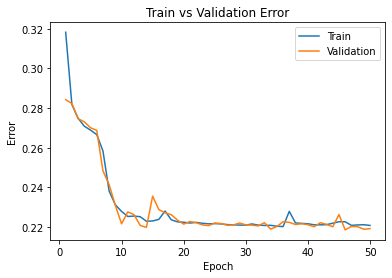

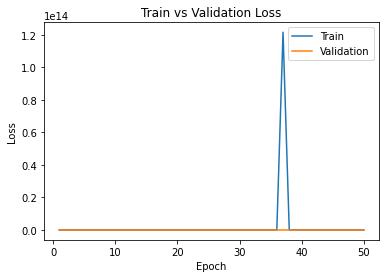

In [83]:
'''
More epochs
'''
# net = VAENetSmall("ASL_small", transfer_model=None, transfer_ftrs=1000)
net = VanillaVAE(3, 10)
net.name = "vanilla"


batch = 64
lr = 0.01
m = 0.9
epochs = 50

train_network(net, batch_size=batch, lr=lr, momentum=m, num_epochs=epochs, cuda=True)
model_path =  OUTPUT_DIR + get_model_name(net.name, batch, lr, m, epochs-1)
plot_training_curve(model_path)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

torch.cuda.empty_cache()

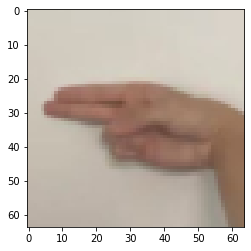

torch.Size([1, 3, 64, 64])


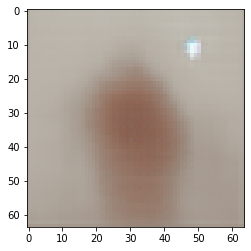

tensor([[[0.3953, 0.4479, 0.4495,  ..., 0.4479, 0.4355, 0.3985],
         [0.4203, 0.4669, 0.4723,  ..., 0.4671, 0.4611, 0.4126],
         [0.4207, 0.4637, 0.4614,  ..., 0.4627, 0.4518, 0.4118],
         ...,
         [0.3381, 0.3353, 0.3344,  ..., 0.2941, 0.3143, 0.3019],
         [0.3470, 0.3462, 0.3497,  ..., 0.3040, 0.3228, 0.3129],
         [0.3122, 0.3078, 0.3082,  ..., 0.2765, 0.2909, 0.2823]],

        [[0.3542, 0.4130, 0.4252,  ..., 0.4148, 0.4061, 0.3452],
         [0.3692, 0.4231, 0.4246,  ..., 0.4227, 0.4110, 0.3547],
         [0.3667, 0.4208, 0.4225,  ..., 0.4203, 0.4090, 0.3560],
         ...,
         [0.2609, 0.2534, 0.2526,  ..., 0.1882, 0.2257, 0.2213],
         [0.2832, 0.2764, 0.2844,  ..., 0.2146, 0.2499, 0.2442],
         [0.2170, 0.2083, 0.2122,  ..., 0.1642, 0.1900, 0.1942]],

        [[0.2712, 0.3405, 0.3511,  ..., 0.3422, 0.3344, 0.2698],
         [0.2936, 0.3450, 0.3501,  ..., 0.3450, 0.3321, 0.2757],
         [0.2919, 0.3451, 0.3431,  ..., 0.3437, 0.3280, 0.

In [86]:
train_dl, val_dl, _ = get_data_loaders(batch_size=1)

net.eval()
net = net.to('cpu')
for data in val_dl:
    img, _, _ = data
    imshow(img[0])
    
    out = net(img)
    out = out[0].detach()
    print(out.shape)
    imshow(out[0])
    print(out[0])
    break